# Turbofan Engine Degradation 

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge
import xgboost as xg 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',200)


 # Wrangle Function 

In [2]:
##Wrangle
def wrangle(set_):
    ## Set variables
        
    df=[0]*5
    dft=[0]*5
    ruldf=[0]*5
    ruldft=[0]*5
    drop_cols=[0]*5
    n_=['']*21
    ## Set column names:        
    for i in range(0,21):
        n_[i]='sens_meas_'+str(i+1)
        col_names=['unit_no', 'time', 'op_set1', 'op_set2', 'op_set3']+ n_

    if (set_ == 'train') or (set_ == 'test'):
        





    ## Read csvs and assign them to df[1] to df[4]
        for n in range(1,5):
            string = './data/' + set_ + '_FD00*.txt'
            files = glob(string)
            file = files[n-1]
        #     #Import filenames

            file= file.replace('\\', '/')

            df_=pd.read_csv(file, delimiter=" ", names=col_names, header=None, index_col=False)
            df_=df_.set_index('unit_no')

    #Drop columns with a single value accross all rows
            drop_cols_ = [col for col in df_
                       if df_[col].nunique() == 1]
            df[n]=df_.drop(columns = drop_cols_)

    ##Create Remaining Useful Life column (RUL), which is = to the number of readings before failure 
            # (the last reading for each unit is in this dataset represents failure)
            ruldf[n]=df[n][['time']].groupby(by='unit_no').max()
            for x in ruldf[n].index:
                df[n].loc[x,'RUL'] = ruldf[n].loc[x,'time'] - df[n].loc[x,'time']



    ###### Running Averages
            ##Create N days running average column:
        

    ######################
    ### Uncomment to only perform RA to sensor columns:
    #       cols = df1.loc[:,df1.columns.str.contains('sens')].columns ### Uncomment to only perform RA to sensor columns
    ###
            df_=df[n]
            cols = df_.drop(columns=['time','RUL']).columns 
            ra_col_names = cols.astype(str) + '_RA'
            
    ######## Data Inputs #####################################
    
            N=10          ##Running Average number
        
    ##########################################################


            for x in range(len(cols)): # For each column where RA will be performed
                for i in range(df[n].index.nunique()):   # For each unit (motor)
                    temp_ = df[n].loc[(df[n].index==i+1) & (df[n]['time']<N),cols[x]] 
                    conv= np.convolve(df[n].loc[df[n].index==i+1,cols[x]], np.ones(N)/N, mode='valid')
                    df[n].loc[i+1,ra_col_names[x]] = np.append(temp_,conv)
                    

    else:
        for n in range(1,5):
            string = './data/RUL_FD00*.txt'
            files = glob(string)
            file = files[n-1]
            file= file.replace('\\', '/')
            dfr_=pd.read_csv(file, names=['RUL'], header=None)  ## Set imported csv as dfr_
            dfr_=dfr_.set_index(dfr_.index+1) ##Set index to Unit No.

            ### Read test file to acquire time column:
            string = './data/test_FD00*.txt'
            files = glob(string)
            file = files[n-1]
            file= file.replace('\\', '/')

            time_col = pd.read_csv(file, delimiter=" ", names=col_names, header=None, index_col=False)
            time_col = time_col.set_index('unit_no')
            time_col = time_col[['time']]          
            time_col.loc[:,'RUL'] = 0
            
            for u in time_col.index:
                time_col.loc[u,'RUL'] = (time_col.loc[u,'time'] == time_col.loc[u,'time'].max()).astype(int)
    

            for i in reversed(range(len(time_col))):
                if time_col.iloc[i,1] == 1:
                    time_col.iloc[i,1] = dfr_.loc[time_col.iloc[i].name][0]
                else:
                    time_col.iloc[i,1] = time_col.iloc[i+1,1]+1

            df[n] = time_col.drop(columns=['time'])

    return df

#### Set variables

In [3]:
df = wrangle('train')
dft = wrangle('test')
dfr = wrangle('RUL')

## Plot time-RUL graphs to check everything is in order (should be linear with negative slope)

### Train data plots

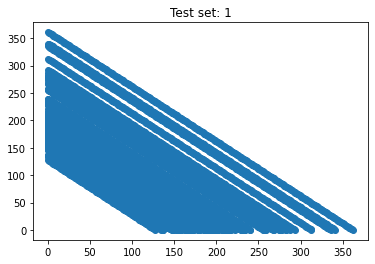

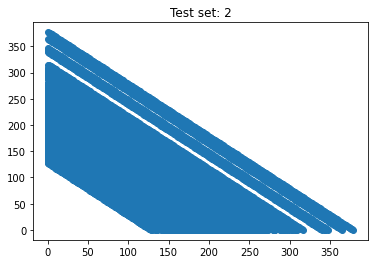

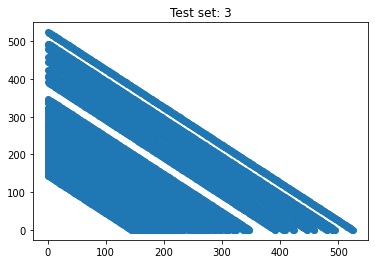

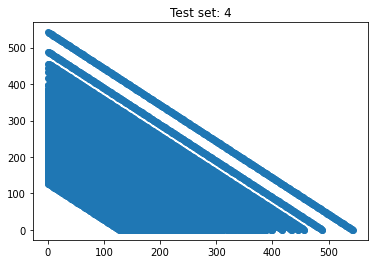

In [370]:
axs=[0]*5
for n in range(1,5):
    fig, axs[n] = plt.subplots();
    title = 'Test set: ' + str(n)
    axs[n].set_title(title)
    print(plt.scatter(df[n]['time'], df[n]['RUL']))
    
    

### Test data plots

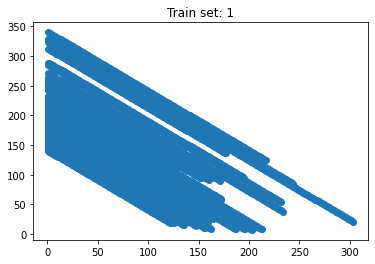

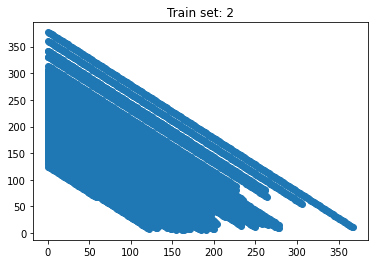

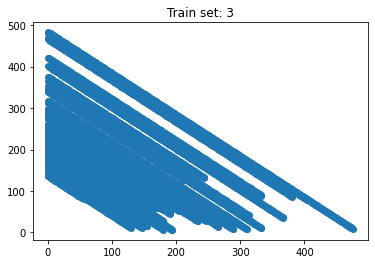

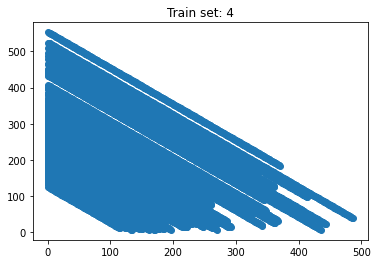

In [371]:
axs=[0]*5
for n in range(1,5):
    fig, axs[n] = plt.subplots()
    title = 'Train set: ' + str(n)
    axs[n].set_title(title)
    print(plt.scatter(dft[n]['time'], dfr[n]['RUL']))
    

# Model

## Split Data

####  Improvement: Add for loop

In [49]:
####  Future improvement: Add for loop
dataset_ =1
df_=df[dataset_]
X_train = df_.drop(columns = ['RUL', 'time'])
y_train = df_['RUL']

dft_ = dft[dataset_]
dfr_ = dfr[dataset_]
X_test = dft_.drop(columns=['RUL', 'time'])
y_test = dfr_['RUL']

# Baseline

In [6]:
#Baseline will be mean for now:
y_pred = [y_train.mean()] * len(y_train)
print('Mean RUL:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))
print("Baseline RMSE  : % f" %(np.sqrt(mean_squared_error(y_train, y_pred)))) 

Mean RUL: 107.80786195530997
Baseline MAE: 56.85860201806482
Baseline RMSE  :  68.879321


# Model

### Random Forest Regressor:

#### Run model:

In [7]:
### Random Forest Regressor with default values:
model_rfr = RandomForestRegressor(random_state=42)
model_rfr.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

#### Check performance (baseline = 56)

In [8]:
print('RFR training MAE:', mean_absolute_error(y_train, model_rfr.predict(X_train)))
print('RFR test MAE:', mean_absolute_error(y_test, model_rfr.predict(X_test)))
print("RFR RMSE  : % f" %(np.sqrt(mean_squared_error(y_test, model_rfr.predict(X_test))))) 

RFR training MAE: 6.720277737385487
RFR test MAE: 36.901434789248626
RFR RMSE  :  48.814432


## Optimize RFR:

In [392]:
estimator = RandomForestRegressor(random_state=42)


params = {
    'n_estimators': range(81,91, 1),
    'max_depth': range(3,11,1)
    }

model_gs = GridSearchCV(
    estimator,
    param_grid=params,
    cv=5,
    n_jobs=-2,
    verbose=1
)

model_gs.fit(X_train, y_train);

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [393]:
print('best parameters: ',model_gs.best_params_)
print('best score: ', model_gs.best_score_)

best parameters:  {'max_depth': 5, 'n_estimators': 89}
best score:  0.6864666098543952


#### Run model again with obtained parameters

In [9]:
model_rfr = RandomForestRegressor(random_state=42, n_jobs=-2, n_estimators = 89, max_depth=5)
model_rfr.fit(X_train,y_train)

RandomForestRegressor(max_depth=5, n_estimators=89, n_jobs=-2, random_state=42)

In [10]:
print('RFR training MAE:', mean_absolute_error(y_train, model_rfr.predict(X_train)))
print('RFR test MAE:', mean_absolute_error(y_test, model_rfr.predict(X_test)))
print()
print("RFR RMSE Train : % f" %(np.sqrt(mean_squared_error(y_train, model_rfr.predict(X_train)))))
print("RFR RMSE Test : % f" %(np.sqrt(mean_squared_error(y_test, model_rfr.predict(X_test))))) 

RFR training MAE: 28.14182523767319
RFR test MAE: 35.44915854812884

RFR RMSE Train :  39.827421
RFR RMSE Test :  46.860552


## Logistic Regression

#### Run model:

In [11]:
model_lr = LogisticRegression(max_iter=500, n_jobs=-2)
model_lr.fit(X_train,y_train)

LogisticRegression(max_iter=500, n_jobs=-2)

#### Check performance (baseline = 56)

In [12]:
print('LR training MAE:', mean_absolute_error(y_train, model_lr.predict(X_train)))
print('LR test MAE:', mean_absolute_error(y_test, model_lr.predict(X_test)))
print()
print("LR RMSE Train : % f" %(np.sqrt(mean_squared_error(y_train, model_lr.predict(X_train)))))
print("LR RMSE Test : % f" %(np.sqrt(mean_squared_error(y_test, model_lr.predict(X_test))))) 

LR training MAE: 35.33139450341719
LR test MAE: 42.11728772144166

LR RMSE Train :  50.692981
LR RMSE Test :  57.026797


## Ridge Regression

In [19]:
model_rr=Ridge(alpha = 0.006238297763154342)
model_rr.fit(X_train,y_train)

Ridge(alpha=0.006238297763154342)

In [20]:
print("RR RMSE Train : % f" %(np.sqrt(mean_squared_error(y_train, model_rr.predict(X_train)))))
print("RR RMSE Test : % f" %(np.sqrt(mean_squared_error(y_test, model_rr.predict(X_test))))) 

RR RMSE Train :  44.092538
RR RMSE Test :  47.911506


### Optimize alpha:

In [22]:
alphas = 10**np.linspace(10,-2,1000)*0.5
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
print('Alpha = ',ridgecv.alpha_)

Alpha =  0.005


#### Run model again with obtained alpha

In [23]:
model_rr=Ridge(alpha = ridgecv.alpha_)
model_rr.fit(X_train,y_train)

Ridge(alpha=0.005)

In [414]:
print("RR RMSE Train : % f" %(np.sqrt(mean_squared_error(y_train, model_rr.predict(X_train)))))
print("RR RMSE Test : % f" %(np.sqrt(mean_squared_error(y_test, model_rr.predict(X_test))))) 

RR RMSE Train :  40.288524
RR RMSE Test :  42.841941


### XGBoost

#### Run model:

In [27]:
# Instantiation 
model_xg = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 5) 
  
# Fitting the model 
model_xg.fit(X_train, y_train) 
  
# Predict the model 
pred = model_xg.predict(X_test) 


#### Check performance (baseline = 56)

In [28]:
model=model_xg
print('XGB training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
print('XGB test MAE:', mean_absolute_error(y_test, model.predict(X_test)))
# # RMSE Computation 
print()
print("RMSE Train : % f" %(np.sqrt(mean_squared_error(y_train, model_xg.predict(X_train)))))
print("RMSE Test : % f" %(np.sqrt(mean_squared_error(y_test, model_xg.predict(X_test))))) 

XGB training MAE: 29.230657036886566
XGB test MAE: 38.85913642747561

RMSE Train :  42.641032
RMSE Test :  53.207490


# Figures:

## Setpoints and Sensors vs. time

In [382]:
df[1]['sens_meas_6'].value_counts()

21.61    20225
21.60      406
Name: sens_meas_6, dtype: int64

Columns plotted:  Index(['op_set1', 'op_set2', 'sens_meas_2', 'sens_meas_3', 'sens_meas_4',
       'sens_meas_6', 'sens_meas_7', 'sens_meas_8', 'sens_meas_9',
       'sens_meas_11', 'sens_meas_12', 'sens_meas_13', 'sens_meas_14',
       'sens_meas_15', 'sens_meas_17', 'sens_meas_20', 'sens_meas_21'],
      dtype='object')


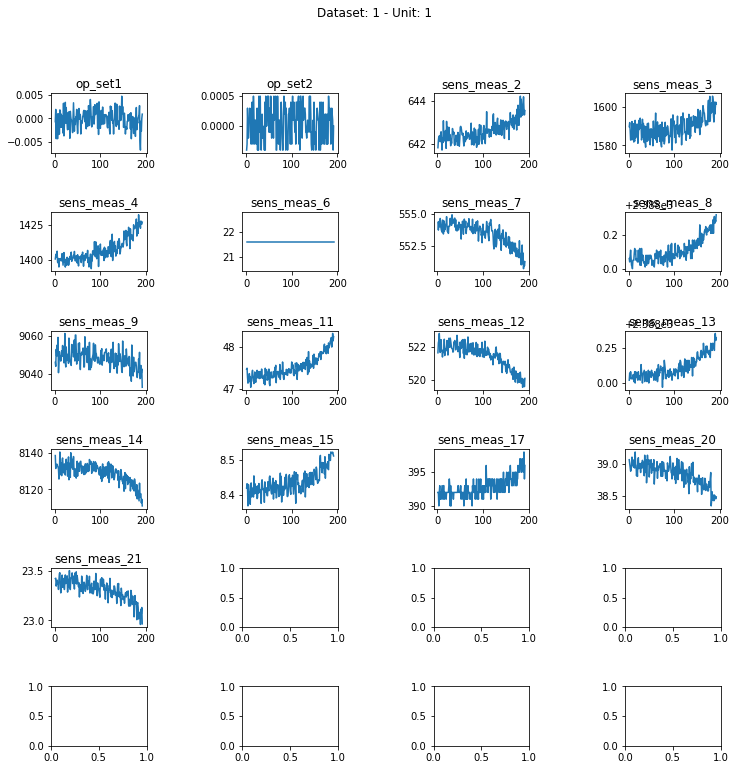

In [380]:
### Input Variables ###################################################

set_ = 1    # Select dataset (between 1 and 4)
unit_ = 1   # Select unit to plot

####################################################################### 

data = df[set_]
data = data[data.index == unit_]
col_drop_ = [col for col in data.columns if col.find('R') !=-1 ]
time_ = data['time']
data = data.drop(columns = col_drop_)
data = data.drop(columns='time')

col=data.columns
print('Columns plotted: ', col)


fig, axs = plt.subplots(6, 4)
for c in range(0,len(data.columns)):
#     if 1<=c<=4:
    axs[int(c/4),c%4].plot(time_, data[col[c]])
    axs[int(c/4), c%4].set_title(col[c])

fig.subplots_adjust(wspace=1,hspace=1)
fig.set_size_inches(12,12)
title = 'Dataset: ' + str(set_) + ' - Unit: ' + str(unit_); 
fig.suptitle(title);


## Running Averages vs. time

Columns plotted:  Index(['op_set1_RA', 'op_set2_RA', 'sens_meas_2_RA', 'sens_meas_3_RA',
       'sens_meas_4_RA', 'sens_meas_6_RA', 'sens_meas_7_RA', 'sens_meas_8_RA',
       'sens_meas_9_RA', 'sens_meas_11_RA', 'sens_meas_12_RA',
       'sens_meas_13_RA', 'sens_meas_14_RA', 'sens_meas_15_RA',
       'sens_meas_17_RA', 'sens_meas_20_RA', 'sens_meas_21_RA'],
      dtype='object')


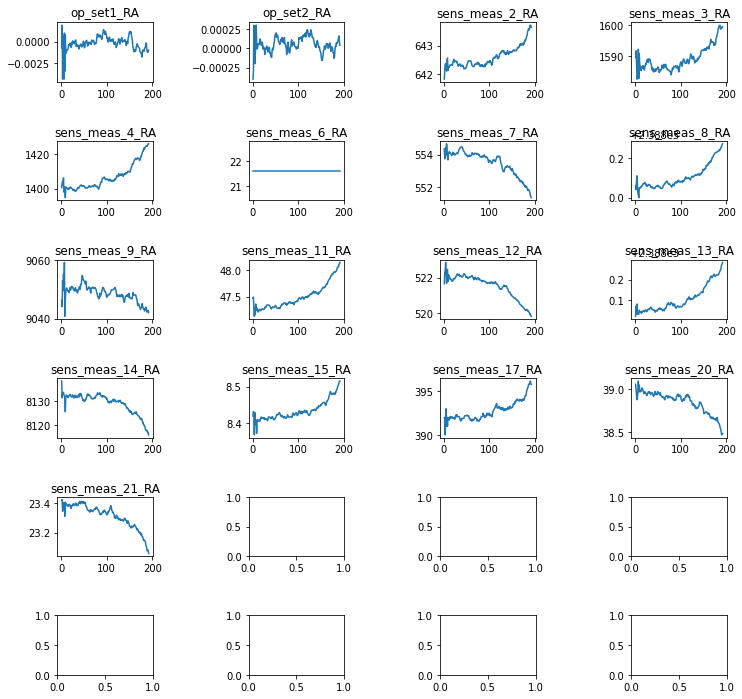

In [37]:
### Input Variables ###################################################

set_ = 1    # Select dataset (between 1 and 4)
unit_ = 1   # Select unit to plot

####################################################################### 

data = df[set_]
data = data[data.index == unit_]
col_drop_ = [col for col in data.columns if col.find('RA') ==-1 ]
col_drop_.remove('time')
# data_ra = data[col_drop_]
# data_ra = data_ra.drop(columns = 'RUL')
time_ = data['time']
data = data.drop(columns='time')
data = data.drop(columns = col_drop_)


col=data.columns
print('Columns plotted: ', col)


fig, axs = plt.subplots(6, 4)
for c in range(0,len(data.columns)):
#     if 1<=c<=4:
    axs[int(c/4),c%4].plot(time_, data[col[c]])
    axs[int(c/4), c%4].set_title(col[c])
#     if 5<=c<=8:
#         axs[1,c%4].plot(data.loc[data.index == c, 'time'], data.loc[data.index == c, col])
#     if 9<=c<=12:
#         axs[2,c%4].plot(data.loc[data.index == c, 'time'], data.loc[data.index == c, col])
#     if 13<=c<=16:
#         axs[3,c%4].plot(data.loc[data.index == c, 'time'], data.loc[data.index == c, col])
#     if 17<=c<=20:
#         axs[4,c%4].plot(data.loc[data.index == c, 'time'], data.loc[data.index == c, col])
#     if 21<=c<=24:
#         axs[5,c%4].plot(data.loc[data.index == c, 'time'], data.loc[data.index == c, col])
#   
# for n in range(24):
#     row_ = int(n/4)
#     col_ = n%4
#     axs[row_, col_].set_title(col[n])
# axs[0, 0].set_title(col)
# axs[0, 1].set_title(col)
# axs[0, 2].set_title(col)
# axs[0, 3].set_title(col)
fig.subplots_adjust(wspace=1,hspace=1)
fig.set_size_inches(12,12)



# Permutation importance

In [30]:
models = [model_rfr, model_lr, model_rr, model_xg]
model_scores = pd.DataFrame()
for n in range(0,4):
    model_scores['model'] = ['model_rfr', 'model_lr', 'model_rr', 'model_xg']
    model_scores.loc[n,'score'] = (np.sqrt(mean_squared_error(y_test, models[n].predict(X_test))))


In [31]:
min_score = model_scores['score'].min()
print ('The best model score was: \n', model_scores[model_scores['score'] == min_score])


The best model score was: 
        model      score
0  model_rfr  46.860552


In [35]:
model_scores

,model,score
0,model_rfr,46.860552
1,model_lr,57.026797
2,model_rr,47.917351
3,model_xg,53.207490


In [32]:
#Import:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(model_rr,
                                  X_test, 
                                  y_test, 
                                  n_jobs=-2, 
                                  random_state=42)

In [33]:
data_pm = pd.DataFrame({'importances_mean': perm_imp['importances_mean']}, index = X_test.columns)

Text(0.5, 1.0, 'Permutation Importances  for features in model_rfr (no time column), dataset 1')

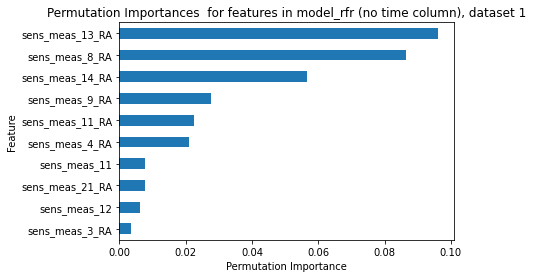

In [52]:
data_pm['importances_mean'].sort_values().tail(10).plot(kind='barh')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
title = 'Permutation Importances  for features in model_rfr (no time column), dataset '+ str(dataset_)
plt.title(title)